<a href="https://colab.research.google.com/github/ilEnzio/DS-Unit-2-Linear-Models/blob/master/ERLE_GRANGERII_DS18_DS_Sprint_Challenge_5_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Linear Models Sprint Challenge

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

### Part 1, Classification
- 1.1. Do train/test split. Arrange data into X features matrix and y target vector
- 1.2. Use scikit-learn to fit a logistic regression model
- 1.3. Report classification metric: accuracy

### Part 2, Regression
- 2.1. Begin with baselines for regression
- 2.2. Do train/validate/test split
- 2.3. Arrange data into X features matrix and y target vector
- 2.4. Do one-hot encoding
- 2.5. Use scikit-learn to fit a linear regression or ridge regression model
- 2.6. Report validation MAE and $R^2$

### Stretch Goals, Regression
- Make at least 2 visualizations to explore relationships between features and target. You may use any visualization library
- Try at least 3 feature combinations. You may select features manually, or automatically
- Report validation MAE and $R^2$ for each feature combination you try
- Report test MAE and $R^2$ for your final model
- Print or plot the coefficients for the features in your model

In [546]:
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*

# Part 1, Classification: Predict Blood Donations 🚑
Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict whether the donor made a donation in March 2007, using information about each donor's history.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

In [547]:
import pandas as pd

donors = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')
assert donors.shape == (748,5)

donors = donors.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

Notice that the majority class (did not donate blood in March 2007) occurs about 3/4 of the time. 

This is the accuracy score for the "majority class baseline" (the accuracy score we'd get by just guessing the majority class every time).

In [548]:
donors['made_donation_in_march_2007'].value_counts(normalize=True)

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64

## Import Libraries and Modules

In [549]:
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split


# special sauce for custom method :) 
from collections import namedtuple

# ML models
from sklearn.linear_model import LinearRegression # old reliable model, for continous
from sklearn.linear_model import Ridge # RidgeRegression to guard against overfit
from sklearn.linear_model import LogisticRegression # used to predict categorical vectors


# Metric accessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Transformers
from category_encoders import OneHotEncoder # splits cat variable 
import category_encoders as ce
from sklearn.feature_selection import SelectKBest # selects highest correlating features
from sklearn.impute import SimpleImputer

# Lets us combine the steps for making a model
from sklearn.pipeline import Pipeline

## Some EDA/Wrangle

In [550]:
donors_df = donors.copy()
donors_df.shape

(748, 5)

In [551]:
#lets write a function real quick to save time

# need to set this to get the display to work
pd.set_option('display.max_columns', None)

def eda_stuff(df):
  print('\033[1m' "Info:" '\033[0m')
  print(df.info())
  print()
  print('\033[1m' "Head:" '\033[0m')
  print(df.head(2))
  print()
  print('\033[1m' "Numeric Features:" '\033[0m')
  print(df.describe())
  print()
  

In [552]:
eda_stuff(donors_df)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   months_since_last_donation   748 non-null    int64
 1   number_of_donations          748 non-null    int64
 2   total_volume_donated         748 non-null    int64
 3   months_since_first_donation  748 non-null    int64
 4   made_donation_in_march_2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None

Head:
   months_since_last_donation  number_of_donations  total_volume_donated  \
0                           2                   50                 12500   
1                           0                   13                  3250   

   months_since_first_donation  made_donation_in_march_2007  
0                           98                            1  
1                           28                            1  

Numeric Features:
       months

In [553]:
donors_df["made_donation_in_march_2007"].value_counts()

0    570
1    178
Name: made_donation_in_march_2007, dtype: int64

### From this I know:
**Y_Vector** = made_donation_in_march_2007

**Desired Shape:** I want no more than 59-95 features (Based on Training Observations = .8 of .8 of Feature Matrix, Divided by 5 or preferably 8) To minimize the Curse of Dimensionality.  So we will be safe.

**No Categorical Variables...** Hmmm...

  * Change made_donation_in_march_2007 to Categorical

**No NaNs** that I can see...

In [554]:
# change made donation 2007 to categorical
donors_df["made_donation_in_march_2007"] = donors_df["made_donation_in_march_2007"].astype("category")

In [555]:
donors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   months_since_last_donation   748 non-null    int64   
 1   number_of_donations          748 non-null    int64   
 2   total_volume_donated         748 non-null    int64   
 3   months_since_first_donation  748 non-null    int64   
 4   made_donation_in_march_2007  748 non-null    category
dtypes: category(1), int64(4)
memory usage: 24.3 KB


## 1.1. Do train/test split. Arrange data into X features matrix and y target vector

Do these steps in either order.

Use scikit-learn's train/test split function to split randomly. (You can include 75% of the data in the train set, and hold out 25% for the test set, which is the default.)

### Create Feature Maxtrix


In [556]:
### Create Feature Maxtrix

X_matrix = donors_df.drop(labels="made_donation_in_march_2007", axis=1)
X_matrix.shape

(748, 4)

### Create Target Vector

In [557]:
# I like to put it in a dataframe because I've run into problems before...
y_target = donors_df["made_donation_in_march_2007"].to_frame()
y_target.shape

(748, 1)

### Do the Train/Test split - hold out 25% for test

In [558]:
# 
X_train, X_test, y_train, y_test = train_test_split(
    X_matrix, y_target, train_size=0.75, test_size=0.25, random_state=42)

In [559]:
#check the shapes for sanity...
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(561, 4)
(187, 4)
(561, 1)
(187, 1)


## 1.2. Use scikit-learn to fit a logistic regression model

You may use any number of features

### Let's do another split As a **Validation Set**

In [560]:
#
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.8, test_size=0.20, random_state=42)

In [561]:
#another check of shapes for sanity...
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(448, 4)
(113, 4)
(448, 1)
(113, 1)


## There are no nulls, and we don't really need to one hot encode... but let's make pipeline for practice...

In [562]:
log_reg_model = Pipeline([ 
      ("regressor", LogisticRegression())])

log_reg_model.fit(X_train, y_train)

y_pred_log = log_reg_model.predict(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 1.3. Report classification metric: accuracy

What is your model's accuracy on the test set?

Don't worry if your model doesn't beat the majority class baseline. That's okay!

_"The combination of some data and an aching desire for an answer does not ensure that a reasonable answer can be extracted from a given body of data."_ —[John Tukey](https://en.wikiquote.org/wiki/John_Tukey)

(Also, if we used recall score instead of accuracy score, then your model would almost certainly beat the baseline. We'll discuss how to choose and interpret evaluation metrics throughout this unit.)


In [563]:
print('Training Accuracy:', log_reg_model.score(X_train, y_train))
print('Validation Accuracy:', log_reg_model.score(X_val, y_val))
print('Test Accuracy:', log_reg_model.score(X_test, y_test))
print("Compared to a baseline...")
print(f"Basline Accuracy Score: {donors['made_donation_in_march_2007'].value_counts(normalize=True).max()}")


Training Accuracy: 0.7924107142857143
Validation Accuracy: 0.7256637168141593
Test Accuracy: 0.7540106951871658
Compared to a baseline...
Basline Accuracy Score: 0.7620320855614974


# Part 2, Regression: Predict home prices in Ames, Iowa 🏠

You'll use historical housing data. ***There's a data dictionary at the bottom of the notebook.*** 

Run this code cell to load the dataset:





In [564]:
import pandas as pd
URL = 'https://drive.google.com/uc?export=download&id=1522WlEW6HFss36roD_Cd9nybqSuiVcCK'
homes = pd.read_csv(URL)
assert homes.shape == (2904, 47)

In [565]:
#lets write a function real quick to save time

# need to set this to get the display to work
pd.set_option('display.max_columns', None)

def eda_stuff(df):
  print('\033[1m' "Info:" '\033[0m')
  print(df.info())
  print()
  print('\033[1m' "Head:" '\033[0m')
  print(df.head(2))
  print()
  print('\033[1m' "Numeric Features:" '\033[0m')
  print(df.describe())
  print()
  print('\033[1m' "Categorical Features:" '\033[0m')
  print(df.describe(exclude="number"))

## Some EDA/Wrangle

In [566]:
ames_homes_df = homes.copy()

In [567]:
eda_stuff(ames_homes_df)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2904 entries, 0 to 2903
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   1st_Flr_SF      2904 non-null   int64  
 1   Bedroom_AbvGr   2904 non-null   int64  
 2   Bldg_Type       2904 non-null   object 
 3   Bsmt_Full_Bath  2904 non-null   float64
 4   Bsmt_Half_Bath  2904 non-null   float64
 5   Central_Air     2904 non-null   object 
 6   Condition_1     2904 non-null   object 
 7   Condition_2     2904 non-null   object 
 8   Electrical      2904 non-null   object 
 9   Exter_Cond      2904 non-null   object 
 10  Exter_Qual      2904 non-null   object 
 11  Exterior_1st    2904 non-null   object 
 12  Exterior_2nd    2904 non-null   object 
 13  Foundation      2904 non-null   object 
 14  Full_Bath       2904 non-null   int64  
 15  Functional      2904 non-null   object 
 16  Gr_Liv_Area     2904 non-null   int64  
 17  Half_Bath       2904 non-nu

In [568]:
ames_homes_df.columns

Index(['1st_Flr_SF', 'Bedroom_AbvGr', 'Bldg_Type', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Central_Air', 'Condition_1', 'Condition_2',
       'Electrical', 'Exter_Cond', 'Exter_Qual', 'Exterior_1st',
       'Exterior_2nd', 'Foundation', 'Full_Bath', 'Functional', 'Gr_Liv_Area',
       'Half_Bath', 'Heating', 'Heating_QC', 'House_Style', 'Kitchen_AbvGr',
       'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Lot_Area', 'Lot_Config',
       'Lot_Shape', 'MS_SubClass', 'MS_Zoning', 'Mas_Vnr_Type', 'Mo_Sold',
       'Neighborhood', 'Overall_Cond', 'Overall_Qual', 'Paved_Drive',
       'Roof_Matl', 'Roof_Style', 'SalePrice', 'Sale_Condition', 'Sale_Type',
       'Street', 'TotRms_AbvGrd', 'Utilities', 'Year_Built', 'Year_Remod/Add',
       'Yr_Sold'],
      dtype='object')

In [569]:
ames_homes_df['Yr_Sold'].value_counts()

2007    686
2009    644
2006    621
2008    613
2010    340
Name: Yr_Sold, dtype: int64

In [570]:
ames_homes_df['Year_Remod/Add'].value_counts()

1950    360
2006    199
2007    155
2005    141
2004    111
       ... 
1981     13
1986     13
2010     13
1983     11
1982      9
Name: Year_Remod/Add, Length: 61, dtype: int64

In [571]:
ames_homes_df['Year_Built'].value_counts()

2005    141
2006    131
2007    104
2004     99
2003     86
       ... 
1875      1
1907      1
1911      1
1913      1
1872      1
Name: Year_Built, Length: 118, dtype: int64

In [572]:
ames_homes_df["Mo_Sold"].value_counts()

6     505
7     445
5     391
4     275
8     231
3     230
10    171
9     157
11    141
2     133
1     123
12    102
Name: Mo_Sold, dtype: int64

In [573]:
ames_homes_df["Overall_Cond"].value_counts()

5    1632
6     532
7     388
8     144
4     101
3      49
9      41
2      10
1       7
Name: Overall_Cond, dtype: int64

In [574]:
ames_homes_df["Overall_Qual"].value_counts()

5     823
6     728
7     592
8     342
4     225
9     107
3      40
10     30
2      13
1       4
Name: Overall_Qual, dtype: int64

In [575]:
#  ??? this looks like a category...
ames_homes_df["MS_SubClass"].value_counts()

20     1067
60      565
50      287
120     190
30      139
160     129
70      128
80      116
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MS_SubClass, dtype: int64

### From this I know:
**Y_Vector** = SalePrice

**Desired Shape:** I want no more than 370-230 features (Based on Training Observations = .8 of .8 of Feature Matrix, Divided by 5 or preferably 8) To minimize the Curse of Dimensionality.  
* should be fine, but it could get ugly if we OHE everything...

**Variables Stuff...** 

  * Change Mo_Sold to Categorical - might use this to **One Hot Encode**
  * Overall_Cond to Cat 
  * Overall_Qual to cat
  * MS_SubClass to cat
  * Year_Built to datetime
  * Year_Remod/Add to datetime
  * Yr_Sold to ...nvm!!! this messed me up lol all years leave as ints for now..jeez

**No NaNs** that I can see...

In [576]:
# Change the types first
new_types = {'Mo_Sold' : 'category', 'Overall_Cond' : 'category',
             'Overall_Qual' : 'category', 'MS_SubClass' : 'category'}

In [577]:
ames_homes_df= ames_homes_df.astype(new_types)
ames_homes_df.columns

Index(['1st_Flr_SF', 'Bedroom_AbvGr', 'Bldg_Type', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Central_Air', 'Condition_1', 'Condition_2',
       'Electrical', 'Exter_Cond', 'Exter_Qual', 'Exterior_1st',
       'Exterior_2nd', 'Foundation', 'Full_Bath', 'Functional', 'Gr_Liv_Area',
       'Half_Bath', 'Heating', 'Heating_QC', 'House_Style', 'Kitchen_AbvGr',
       'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Lot_Area', 'Lot_Config',
       'Lot_Shape', 'MS_SubClass', 'MS_Zoning', 'Mas_Vnr_Type', 'Mo_Sold',
       'Neighborhood', 'Overall_Cond', 'Overall_Qual', 'Paved_Drive',
       'Roof_Matl', 'Roof_Style', 'SalePrice', 'Sale_Condition', 'Sale_Type',
       'Street', 'TotRms_AbvGrd', 'Utilities', 'Year_Built', 'Year_Remod/Add',
       'Yr_Sold'],
      dtype='object')

In [578]:
ames_homes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2904 entries, 0 to 2903
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   1st_Flr_SF      2904 non-null   int64   
 1   Bedroom_AbvGr   2904 non-null   int64   
 2   Bldg_Type       2904 non-null   object  
 3   Bsmt_Full_Bath  2904 non-null   float64 
 4   Bsmt_Half_Bath  2904 non-null   float64 
 5   Central_Air     2904 non-null   object  
 6   Condition_1     2904 non-null   object  
 7   Condition_2     2904 non-null   object  
 8   Electrical      2904 non-null   object  
 9   Exter_Cond      2904 non-null   object  
 10  Exter_Qual      2904 non-null   object  
 11  Exterior_1st    2904 non-null   object  
 12  Exterior_2nd    2904 non-null   object  
 13  Foundation      2904 non-null   object  
 14  Full_Bath       2904 non-null   int64   
 15  Functional      2904 non-null   object  
 16  Gr_Liv_Area     2904 non-null   int64   
 17  Half_Bath     

### I am dropping columns which I think are redundant or represent data leakage:
#### no need to keep Bedroom and Kitchen above ground when I have TotalRooms Above ground.  Year Sold represents data leakage I think, because the model should know about the result "Sale" in any way, imo

In [579]:
#now I'm going to drop some stuff to create my feature Matrix 
drop_data = ['Bedroom_AbvGr', 'Kitchen_AbvGr', 'Exter_Cond', 'Exter_Qual',
        "Overall_Qual"]


In [580]:
ames_select_df= ames_homes_df.drop(labels=drop_data, axis=1)
ames_select_df.shape

(2904, 42)

In [581]:
y_target = ames_homes_df["SalePrice"].to_frame()
y_target.shape

(2904, 1)

## 2.1. Begin with baselines

What is the Mean Absolute Error and R^2 score for a mean baseline? (You can get these estimated scores using all your data, before splitting it.)

In [582]:
# make function that will do it for us
def get_naive_baseline(target_feature):
  guess = target_feature.mean()
  errors = guess - target_feature
  mean_absolute_error = errors.abs().mean()

  naive_baseline = namedtuple("baseline_info", ["guess", "errors", "MAE"])

  return naive_baseline(guess, errors, mean_absolute_error)

In [583]:
nbaseline = get_naive_baseline(y_target)

In [584]:
print(f"If we guessed: {nbaseline.guess}")
print(f"Our MAE would be: {nbaseline.MAE}")

If we guessed: SalePrice    180383.689738
dtype: float64
Our MAE would be: SalePrice    58149.927741
dtype: float64


## 2.2. Do train/validate/test split

Train on houses sold in the years 2006 - 2008. (1,920 rows)

Validate on house sold in 2009. (644 rows)

Test on houses sold in 2010. (340 rows)

In [585]:
ames_select_df["Yr_Sold"].value_counts()

2007    686
2009    644
2006    621
2008    613
2010    340
Name: Yr_Sold, dtype: int64

In [586]:
cond_2009_Temptrain = ames_select_df["Yr_Sold"] <= 2009
cond_2009_Temptrain

0       False
1       False
2       False
3       False
4       False
        ...  
2899     True
2900     True
2901     True
2902     True
2903     True
Name: Yr_Sold, Length: 2904, dtype: bool

In [587]:
#split out the (train + val) from test
X_train, y_train = ames_select_df.loc[cond_2009_Temptrain], y_target.loc[cond_2009_Temptrain]
X_test, y_test = ames_select_df.loc[~cond_2009_Temptrain], y_target.loc[~cond_2009_Temptrain]

In [588]:
print(ames_select_df.shape)

print(X_train.shape)
print(X_test.shape)

(2904, 42)
(2564, 42)
(340, 42)


In [589]:
print(y_target.shape)
print(y_train.shape)

print(y_test.shape)

(2904, 1)
(2564, 1)
(340, 1)


In [590]:
# now seperate the train from validation for use
cond_2009_val = X_train["Yr_Sold"] == 2009
cond_2009_val

340      True
341      True
342      True
343      True
344      True
        ...  
2899    False
2900    False
2901    False
2902    False
2903    False
Name: Yr_Sold, Length: 2564, dtype: bool

In [591]:
cond_less2009_train = X_train["Yr_Sold"] < 2009
cond_less2009_train

340     False
341     False
342     False
343     False
344     False
        ...  
2899     True
2900     True
2901     True
2902     True
2903     True
Name: Yr_Sold, Length: 2564, dtype: bool

In [592]:
X_val, y_val = X_train.loc[cond_2009_val], y_train.loc[cond_2009_val]
X_train, y_train = X_train.loc[cond_less2009_train], y_train.loc[cond_less2009_train]


In [593]:
# I've already gone INSANE but sanity check anyway...
print(ames_select_df.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2904, 42)
(1920, 42)
(644, 42)
(340, 42)


In [594]:
print(ames_select_df.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2904, 42)
(1920, 1)
(644, 1)
(340, 1)


## 2.3. Arrange data into X features matrix and y target vector

Select at least one numeric feature and at least one categorical feature.

Otherwise, you may choose whichever features and however many you want.

In [595]:
X_train.columns

Index(['1st_Flr_SF', 'Bldg_Type', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath',
       'Central_Air', 'Condition_1', 'Condition_2', 'Electrical',
       'Exterior_1st', 'Exterior_2nd', 'Foundation', 'Full_Bath', 'Functional',
       'Gr_Liv_Area', 'Half_Bath', 'Heating', 'Heating_QC', 'House_Style',
       'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Lot_Area', 'Lot_Config',
       'Lot_Shape', 'MS_SubClass', 'MS_Zoning', 'Mas_Vnr_Type', 'Mo_Sold',
       'Neighborhood', 'Overall_Cond', 'Paved_Drive', 'Roof_Matl',
       'Roof_Style', 'SalePrice', 'Sale_Condition', 'Sale_Type', 'Street',
       'TotRms_AbvGrd', 'Utilities', 'Year_Built', 'Year_Remod/Add',
       'Yr_Sold'],
      dtype='object')

In [596]:
# ok drop the price and stuff from the X_ ones
X_train = X_train.drop(labels= ['Yr_Sold', 'SalePrice'], axis=1)

In [597]:
X_train.shape

(1920, 40)

In [598]:
X_val = X_val.drop(labels= ['Yr_Sold', 'SalePrice'], axis=1)
X_test = X_test.drop(labels= ['Yr_Sold', 'SalePrice'], axis=1)

In [599]:
# make it just continuous.. 
X_train1 = X_train.loc[:, ['1st_Flr_SF', "Mo_Sold"]]
X_val1 = X_val.loc[:, ['1st_Flr_SF', "Mo_Sold"] ]


## 2.4. Do one-hot encoding

Encode your categorical feature(s).

In [600]:
#Instantiate the Transformer
encoder = ce.OneHotEncoder(cols= ["Mo_Sold"], use_cat_names=True)

# fit and Transform the training data  
XT_train1 = encoder.fit_transform(X_train1)

# don't fit the validation data
XT_val1 = encoder.transform(X_val1)

In [601]:
#it's an ugly one, but I don't have time...
XT_train1.shape

(1920, 13)

In [602]:
XT_train1.head()

,1st_Flr_SF,Mo_Sold_5.0,Mo_Sold_6.0,Mo_Sold_4.0,Mo_Sold_10.0,Mo_Sold_7.0,Mo_Sold_11.0,Mo_Sold_8.0,Mo_Sold_9.0,Mo_Sold_3.0,Mo_Sold_12.0,Mo_Sold_2.0,Mo_Sold_1.0
984,1414,1,0,0,0,0,0,0,0,0,0,0,0
985,2117,1,0,0,0,0,0,0,0,0,0,0,0
986,1092,0,1,0,0,0,0,0,0,0,0,0,0
987,926,0,0,1,0,0,0,0,0,0,0,0,0
988,680,0,0,0,1,0,0,0,0,0,0,0,0


In [603]:
X_test.head()

,1st_Flr_SF,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exterior_1st,Exterior_2nd,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Neighborhood,Overall_Cond,Paved_Drive,Roof_Matl,Roof_Style,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add
0,1656,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,BrkFace,Plywood,CBlock,1,Typ,1656,0,GasA,Fa,1Story,TA,Lvl,Gtl,31770,Corner,IR1,20,RL,Stone,5,NAmes,5,P,CompShg,Hip,Normal,WD,Pave,7,AllPub,1960,1960
1,896,1Fam,0.0,0.0,Y,Feedr,Norm,SBrkr,VinylSd,VinylSd,CBlock,1,Typ,896,0,GasA,TA,1Story,TA,Lvl,Gtl,11622,Inside,Reg,20,RH,None,6,NAmes,6,Y,CompShg,Gable,Normal,WD,Pave,5,AllPub,1961,1961
2,1329,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,Wd Sdng,Wd Sdng,CBlock,1,Typ,1329,1,GasA,TA,1Story,Gd,Lvl,Gtl,14267,Corner,IR1,20,RL,BrkFace,6,NAmes,6,Y,CompShg,Hip,Normal,WD,Pave,6,AllPub,1958,1958
3,2110,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,BrkFace,BrkFace,CBlock,2,Typ,2110,1,GasA,Ex,1Story,Ex,Lvl,Gtl,11160,Corner,Reg,20,RL,None,4,NAmes,5,Y,CompShg,Hip,Normal,WD,Pave,8,AllPub,1968,1968
4,928,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,VinylSd,VinylSd,PConc,2,Typ,1629,1,GasA,Gd,2Story,TA,Lvl,Gtl,13830,Inside,IR1,60,RL,None,3,Gilbert,5,Y,CompShg,Gable,Normal,WD,Pave,6,AllPub,1997,1998


## 2.5. Use scikit-learn to fit a linear regression or ridge regression model
Fit your model.

### Will use my function to see if it's faster...


In [604]:
def linear_regress_predict(X_train, y_train, X_val, y_val, correlate):

  # X_matrix and y_target
  #  
  # have already split it...
  
  # then it need to instantiate a linear regression object
  lr = LinearRegression()

# then it should fit the model to the trainig data
  lr.fit(X_train, y_train)

  # Then it can make predictions and store them as named tuples:
  # training_MAE, testing_MAE, response_variable
  # now make the predictions

  response_variable = lr.predict([correlate])
  response_var_column = lr.predict(X_train)

  training_MAE = mean_absolute_error(y_train, lr.predict(X_train))
  testing_MAE = mean_absolute_error(y_val, lr.predict(X_val))

  # it can also return the coeffient and intercept
  # coefficient, intercept 

  coefficient = lr.coef_
  intercept = lr.intercept_

  # I think we can also get RSME,  𝑅^2
  model_rmse = mean_squared_error(y_train, response_var_column, squared=False)
  model_r2 = r2_score(y_train, response_var_column)

  model_prediction = namedtuple("prediction_info", ["response_variable",
                                                    "training_MAE", "testing_MAE",
                                                    "model_RMSE", "model_r2_score",
                                                    "coefficient", 
                                                    "intercept"])
  return model_prediction(response_variable[0], training_MAE, testing_MAE,
                          model_rmse, model_r2, coefficient, intercept)

In [605]:
test_correlate = X_val1.iloc[0,:]

In [607]:
prediction = linear_regress_predict(X_train1, y_train, X_val1, y_val, test_correlate)

In [608]:
print(f"Prediction: {prediction.response_variable}")

print(f"Model RMSE: {prediction.model_RMSE}")
print(f"Model R^2: {prediction.model_r2_score}")



print(f"Coefficient: {prediction.coefficient}")
print(f"Intercept: {prediction.intercept}")
print(f"Training MAE: {prediction.training_MAE}")
print(f"Validation MAE: {prediction.testing_MAE}")

Prediction: [149046.14290523]
Model RMSE: 63767.49975390476
Model R^2: 0.36782040722584985
Coefficient: [[124.01290696 520.01694117]]
Intercept: [34466.58955657]
Training MAE: 46397.831535282814
Validation MAE: 45974.05370688454


In [609]:
print(f"If we guessed: {nbaseline.guess}")
print(f"Our MAE would be: {nbaseline.MAE}")

If we guessed: SalePrice    180383.689738
dtype: float64
Our MAE would be: SalePrice    58149.927741
dtype: float64


###So, this model does better than the baseline on average.

## 2.6. Report validation MAE and $R^2$

What is your model's Mean Absolute Error and $R^2$ score on the validation set? (You are not graded on how high or low your validation scores are.)

# Stretch Goals, Regression
- Make at least 2 visualizations to explore relationships between features and target. You may use any visualization library
- Try at least 3 feature combinations. You may select features manually, or automatically
- Report validation MAE and $R^2$ for each feature combination you try
- Report test MAE and $R^2$ for your final model
- Print or plot the coefficients for the features in your model

In [ ]:
some other combination

## Some other combination

### X_train2 = 'TotRms_AbvGrd' and 'Year_Built'


### X_train3 = 'Overall_Cond' and 'Gr_Liv_Area'

In [ ]:
ames_homes_df.TotRms_AbvGrd.value_counts()


In [ ]:
ames_homes_df.Year_Built.value_counts() # will this work?

In [ ]:
ames_select_df.Overall_Cond.value_counts()

In [ ]:
ames_select_df.Gr_Liv_Area.value_counts()

In [616]:
X_train2 = X_train.loc[:, ['TotRms_AbvGrd' ,'Year_Built']]
X_val2 = X_val.loc[:, ['TotRms_AbvGrd' ,'Year_Built'] ]

In [617]:
X_train3 = X_train.loc[:, ['Overall_Cond','Gr_Liv_Area']]
X_val3 = X_val.loc[:, ['Overall_Cond','Gr_Liv_Area'] ]

In [618]:
test_correlate2 = X_val2.iloc[0,:]
test_correlate3 = X_val3.iloc[0,:]

## Combo 2 - 'TotRms_AbvGrd' and 'Year_Built' is the **Best Model of the three.**

In [623]:
prediction2 = linear_regress_predict(X_train2, y_train, X_val2, y_val, test_correlate2)

In [624]:
print(f"Prediction: {prediction2.response_variable}")

print(f"Model RMSE: {prediction2.model_RMSE}")
print(f"Model R^2: {prediction2.model_r2_score}")



print(f"Coefficient: {prediction2.coefficient}")
print(f"Intercept: {prediction2.intercept}")
print(f"Training MAE: {prediction2.training_MAE}")
print(f"Validation MAE: {prediction2.testing_MAE}")

Prediction: [128746.15949671]
Model RMSE: 57434.78896620364
Model R^2: 0.48714835438917103
Coefficient: [[22730.1255667   1296.68704474]]
Intercept: [-2521224.32785273]
Training MAE: 39451.82670457275
Validation MAE: 38252.574462634664


In [626]:
print(f"If we guessed: {nbaseline.guess}")
print(f"Our MAE would be: {nbaseline.MAE}")

If we guessed: SalePrice    180383.689738
dtype: float64
Our MAE would be: SalePrice    58149.927741
dtype: float64


## Combo 3 - 'Overall_Cond' and 'Gr_Liv_Area' is the **worst model** 

In [625]:
prediction3 = linear_regress_predict(X_train3, y_train, X_val3, y_val, test_correlate3)
print(f"Prediction: {prediction3.response_variable}")

print(f"Model RMSE: {prediction3.model_RMSE}")
print(f"Model R^2: {prediction3.model_r2_score}")



print(f"Coefficient: {prediction3.coefficient}")
print(f"Intercept: {prediction3.intercept}")
print(f"Training MAE: {prediction3.training_MAE}")
print(f"Validation MAE: {prediction3.testing_MAE}")

Prediction: [114723.69661731]
Model RMSE: 55766.87321106348
Model R^2: 0.5165024435404613
Coefficient: [[-2319.51429015   109.51361856]]
Intercept: [29730.25649838]
Training MAE: 37387.124341957104
Validation MAE: 41253.555851329256


In [ ]:
print(f"If we guessed: {nbaseline.guess}")
print(f"Our MAE would be: {nbaseline.MAE}")

In [530]:
donors_df.columns

Index(['months_since_last_donation', 'number_of_donations',
       'total_volume_donated', 'months_since_first_donation',
       'made_donation_in_march_2007'],
      dtype='object')

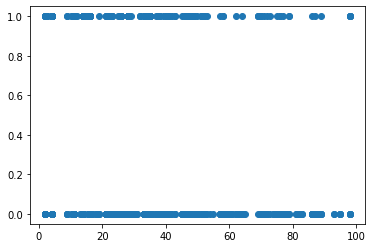

In [532]:
# scatter plots - not too hot...
plt.scatter(donors_df['months_since_first_donation'],donors_df['made_donation_in_march_2007']);

In [533]:
ames_select_df.columns

Index(['1st_Flr_SF', 'Bldg_Type', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath',
       'Central_Air', 'Condition_1', 'Condition_2', 'Electrical',
       'Exterior_1st', 'Exterior_2nd', 'Foundation', 'Full_Bath', 'Functional',
       'Gr_Liv_Area', 'Half_Bath', 'Heating', 'Heating_QC', 'House_Style',
       'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Lot_Area', 'Lot_Config',
       'Lot_Shape', 'MS_SubClass', 'MS_Zoning', 'Mas_Vnr_Type', 'Mo_Sold',
       'Neighborhood', 'Overall_Cond', 'Paved_Drive', 'Roof_Matl',
       'Roof_Style', 'SalePrice', 'Sale_Condition', 'Sale_Type', 'Street',
       'TotRms_AbvGrd', 'Utilities', 'Year_Built', 'Year_Remod/Add',
       'Yr_Sold'],
      dtype='object')

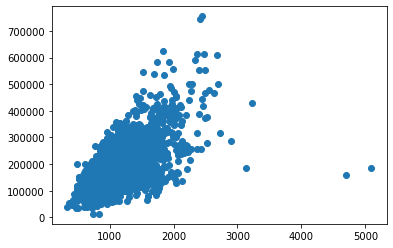

In [535]:
# plt.scatter(ames_select_df['1st_Flr_SF'],ames_select_df['SalePrice']);

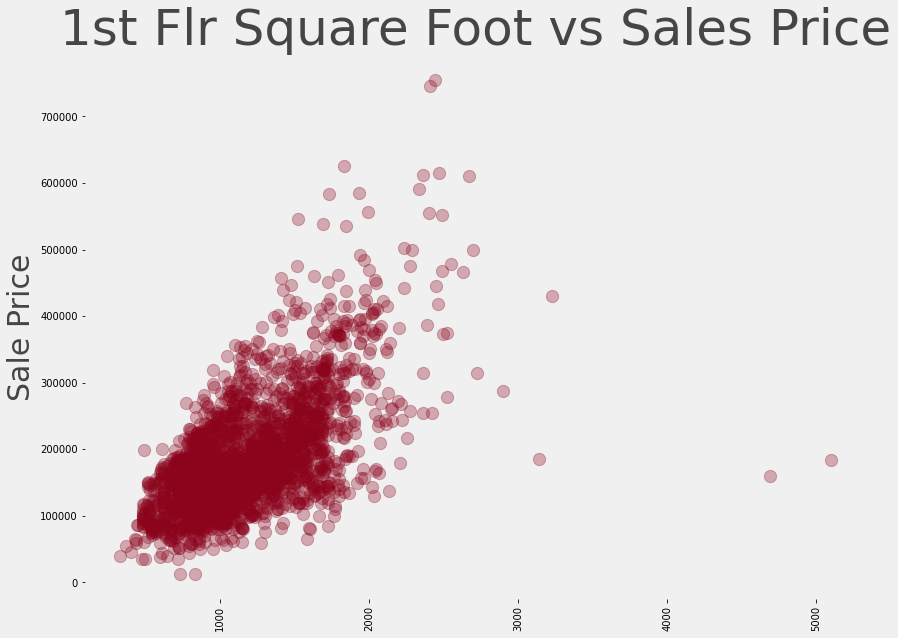

In [545]:
# lets do a better one...
## Scatter plot 1st Flr Square Foot vs Sales Price

dnd_color ="#8C031C"
fig, ax = plt.subplots(figsize = (14,10))

# fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))


# Set bg 

fig.set_facecolor("#F0F0F0")

# set graph background 

ax.set_facecolor("#F0F0F0")

#make graph
plt.scatter(ames_select_df['1st_Flr_SF'],ames_select_df['SalePrice'], alpha=.3, 
            c=dnd_color, s=150)


# label axis
plt.ylabel('Sale Price', fontsize=30, color= "#454545")

# ax.set_yticklabels( fontsize=50, color= "#454545")


# rotate xticks
plt.xticks(rotation=90)

# set title
plt.title('1st Flr Square Foot vs Sales Price', fontsize=50, color= "#454545")


#remove spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)



# plt.savefig("zip_code_vs_total_sales.png")

plt.show()

# Data Dictionary 

Here's a description of the data fields:

```
1st_Flr_SF: First Floor square feet

Bedroom_AbvGr: Bedrooms above grade (does NOT include basement bedrooms)

Bldg_Type: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
       
Bsmt_Half_Bath: Basement half bathrooms

Bsmt_Full_Bath: Basement full bathrooms

Central_Air: Central air conditioning

       N	No
       Y	Yes
		
Condition_1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition_2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
       
 Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
       
 Exter_Cond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
 
 Exter_Qual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Exterior_1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior_2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
Full_Bath: Full bathrooms above grade

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Gr_Liv_Area: Above grade (ground) living area square feet
        
Half_Bath: Half baths above grade

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
Heating_QC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

House_Style: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

Kitchen_AbvGr: Kitchens above grade

Kitchen_Qual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Land_Slope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

Lot_Area: Lot size in square feet

Lot_Config: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

Lot_Shape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

MS_SubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MS_Zoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

Mas_Vnr_Type: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

Mo_Sold: Month Sold (MM)

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Overall_Cond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

Overall_Qual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

Paved_Drive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

Roof_Matl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

Roof_Style: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

SalePrice: the sales price for each house

Sale_Condition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

Sale_Type: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
	
Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
TotRms_AbvGrd: Total rooms above grade (does not include bathrooms)

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
Year_Built: Original construction date

Year_Remod/Add: Remodel date (same as construction date if no remodeling or additions)
						
Yr_Sold: Year Sold (YYYY)	

```